In [75]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import linear_model
import matplotlib.pyplot as plt
from functions import grupowanie, create_probs_series,log_func

In [76]:
#wczytujemy wcześniej przygotowany zbiór

df=pd.read_excel("dumm_credit_card_data.xlsx",index_col="ID")
df['constant']=1

#zmienne objaśniające
features=pd.concat([df.loc[:,:"PAY_AMT6"],df.loc[:,"SEX_2":]],axis=1).columns.tolist()

In [77]:
#tworzymy funkcję do walidacji krzyżowej w ekonometrii

def CV_ekon(df=df,n_splits=5,random_state=111,features=features,*args,**kwargs):
    test_precisions=[]
    probs=[]
    indices=[]
    skf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=random_state)
    for train,test in skf.split(df[features],df.y):
        model=sm.GLM(df.iloc[train].y,df.iloc[train][features],family=sm.families.Binomial(),*args,**kwargs)
        res=model.fit()
        preds=res.predict(df.iloc[test][features]).tolist()
        probs.append(preds)
        indices.append(test.tolist())
        
        #klasyfikacja dotyczy niewypłacalności, klient który nie wywiąże się ze zobowiązania wyszkodzi nam więcej szkody, niż dobry klient zysku
        #użyjemy average_precision do porównywania modeli, ponieważ precyzja jest dla nas najważniejsza w tym problemie
        test_precisions.append(average_precision_score(df.iloc[test].y,preds))
    return test_precisions, probs, indices, res

In [78]:
prec,probs,indices,res=CV_ekon()
print(np.mean(prec))

0.876053738027597


In [79]:
#zobaczmy czy dodanie kwadratu wieku przyniesie poprawę
features2=features.copy()
features2.append('AGE_SQ')
prec,probs,indices,res=CV_ekon(features=features2)
precis=np.mean(prec)
print(precis)
#brak poprawy

0.8759393325541087


In [80]:
#zobaczmy czy dodanie kwadratu zmiennej PAY przyniesie poprawę
features2=features.copy()
features2.extend(df.loc[:,'PAY_0_SQ':'PAY_6_SQ'].columns.tolist())
prec,probs,indices,res=CV_ekon(features=features2)
precis=np.mean(prec)
print(precis)

0.8900947890417414


In [81]:
#poprawa
features=features2.copy()

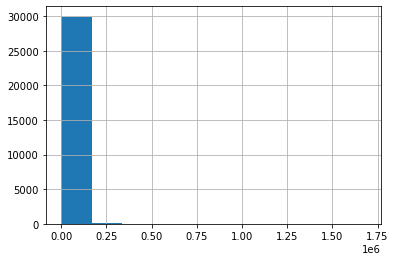

In [82]:
#sprawdzmy rozklad zmiennej wskazanej jako skosna przez pandas profiler
df['PAY_AMT2'].hist(bins=10)
plt.show()

In [84]:
#sprobujemy zlogarytmowac te zmienna
log_func(df=df,column='PAY_AMT2',features=features,precision=precis,valid=CV_ekon)

0.8936778945856144
Poprawa modelu


In [85]:
prec,probs,indices,res=CV_ekon(features=features)
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:                24000
Model:                            GLM   Df Residuals:                    23963
Model Family:                Binomial   Df Model:                           36
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -10834.
Date:                Tue, 05 Oct 2021   Deviance:                       21668.
Time:                        00:36:15   Pearson chi2:                 2.56e+06
No. Iterations:                    21   Pseudo R-squ. (CS):             0.1428
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
LIMIT_BAL     1.459e-06   1.87e-07      7.783      0.000    1.09e-06    1.83e-06
AGE             -0.0030      0.002     -1.394      0.163      -0.007       0.001
PAY_0            0.1649      0.062      2.658      0.008       0.043       0.286
PAY_2           -0.0443      0.075     -0.594      0.553      -0.190       0.102
PAY_3           -0.1064      0.090     -1.179      0.238      -0.283       0.071
PAY_4           -0.2344      0.094     -2.500      0.012      -0.418      -0.051
PAY_5            0.0698      0.091      0.766      0.443      -0.109       0.248
PAY_6            0.3042      0.069      4.385      0.000       0.168       0.440
BILL_AMT1     2.944e-06   1.18e-06      2.504      0.012     6.4e-07    5.25e-06
BILL_AMT2     -2.96e-06   1.43e-06     -2.074      0.038   -5.76e-06   -1.63e-07
BILL_AMT3    -1.501e-06   9.89e-07     -1.517      0.129   -3.44e-06    4.38e-07
BILL_AMT4     4.162e-07   1.33e-06      0.312      0.755    -2.2e-06    3.03e-06
BILL_AMT5    -1.774e-07   1.59e-06     -0.112      0.911   -3.28e-06    2.93e-06
BILL_AMT6    -3.419e-08   1.25e-06     -0.027      0.978   -2.49e-06    2.42e-06
PAY_AMT1      1.062e-05   2.39e-06      4.450      0.000    5.95e-06    1.53e-05
PAY_AMT3      9.075e-09   1.56e-06      0.006      0.995   -3.04e-06    3.06e-06
PAY_AMT4      2.044e-06   1.79e-06      1.144      0.253   -1.46e-06    5.55e-06
PAY_AMT5      1.902e-06   1.91e-06      0.997      0.319   -1.84e-06    5.64e-06
PAY_AMT6      1.701e-06   1.38e-06      1.229      0.219   -1.01e-06    4.41e-06
SEX_2            0.0863      0.035      2.451      0.014       0.017       0.155
EDUCATION_1    -20.7435   1.34e+04     -0.002      0.999   -2.63e+04    2.63e+04
EDUCATION_2    -20.6961   1.34e+04     -0.002      0.999   -2.63e+04    2.63e+04
EDUCATION_3    -20.6506   1.34e+04     -0.002      0.999   -2.63e+04    2.63e+04
EDUCATION_4    -19.6432   1.34e+04     -0.001      0.999   -2.63e+04    2.63e+04
EDUCATION_5    -19.3557   1.34e+04     -0.001      0.999   -2.63e+04    2.63e+04
EDUCATION_6    -20.4075   1.34e+04     -0.002      0.999   -2.63e+04    2.63e+04
MARRIAGE_1      -1.0103      0.554     -1.823      0.068      -2.096       0.076
MARRIAGE_2      -0.8232      0.554     -1.485      0.138      -1.910       0.263
MARRIAGE_3      -1.1213      0.573     -1.957      0.050      -2.244       0.002
constant        22.9452   1.34e+04      0.002      0.999   -2.63e+04    2.63e+04
PAY_0_SQ        -0.1392      0.013    -11.051      0.000      -0.164      -0.115
PAY_2_SQ        -0.0123      0.014     -0.908      0.364      -0.039       0.014
PAY_3_SQ         0.0304      0.017      1.778      0.075      -0.003       0.064
PAY_4_SQ         0.0161      0.017      0.938      0.348      -0.017       0.050
PAY_5_SQ        -0.0258      0.017     -1.518      0.129      -0.059       0.008
PAY_6

In [87]:
#sprobujemy pogrupowac zmienne skorelowane MARRIAGE
#MARRIAGE_1 i MARRIAGE_3 mają podobne współczynniki w regresji, więc pogrupuje je
grupowanie(df,['MARRIAGE_1',"MARRIAGE_3"],'MARRIAGE',CV_ekon,function=sum,features=features,precision=np.mean(prec))

0.8938009663900676
Poprawa modelu


In [88]:
#marriage1 i marriage3 zostały połączone w jedną grupę

In [89]:
#sprobujmy pogrupowac zmienne EDUCATION

In [90]:
kolumny=df.loc[:,'EDUCATION_1':'EDUCATION_3'].columns.tolist()

grupowanie(df=df,columns=kolumny,new_column='EDUCATION',valid=CV_ekon,function=sum,
           features=features,precision=np.mean(prec))

0.893884698227614
Poprawa modelu


In [91]:
#zmodyfikujemy nieco wrapper, aby wykonać regularyzację
def CV_ekon_regul(df=df,n_splits=5,random_state=111,features=features,penalty='none',*args,**kwargs):
    test_precisions=[]
    probs=[]
    indices=[]
    skf=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=random_state)
    for train,test in skf.split(df[features],df.y):
        model=linear_model.LogisticRegression(penalty=penalty,random_state=random_state,*args,**kwargs)
        res=model.fit(df.iloc[train][features],df.iloc[train].y)
        preds=res.predict_proba(df.iloc[test][features])[:,1].tolist()
        probs.append(preds)
        indices.append(test.tolist())
        test_precisions.append(average_precision_score(df.iloc[test].y,preds))
    return test_precisions, probs, indices, res

In [92]:
features2=features.copy()
features2.remove('constant')

In [93]:
test_precisions, probs, indices, res=CV_ekon_regul(max_iter=2000,features=features2)
print(np.mean(test_precisions))
#gorszy wynik dla regresji logistycznej z linear_model

0.8693031173752302


In [94]:
#sprawdzmy czy standaryzacja pomoze
df2=df.copy()

stand_features=df2[features2].dtypes[df2[features2].dtypes!='uint8'].index.tolist()
stand_features.remove("MARRIAGE")
stand_features.remove("EDUCATION")

df2[stand_features]=df2[stand_features].apply(lambda x: (x-x.mean())/x.std())

In [95]:
test_precisions, probs, indices, res=CV_ekon_regul(max_iter=2000,features=features2,df=df2)
print(np.mean(test_precisions))
#tym razem wynik zblizony do regresji logistycznej z linear_model
#sprobujmy użyć regularyzacji z użyciem Lasso i Ridge 

0.8938788567533471


In [96]:
for alpha in [0.01,0.1,1,10,100,1000]:
    test_precisions, probs, indices, res=CV_ekon_regul(C=alpha,max_iter=2000,penalty='l1',solver='liblinear',random_state=111,features=features2,df=df2)
    print(alpha, np.mean(test_precisions))
#brak poprawy dla lasso 

0.01 0.8883139509503886
0.1 0.8927304911748601
1 0.893543536092514
10 0.8936908176930588
100 0.8937404220097219
1000 0.8937397085811524


In [97]:
for alpha in [0.01,0.1,1,10,100,1000,10000,100000]:
    test_precisions, probs, indices, res=CV_ekon_regul(C=alpha,max_iter=2000,penalty='l2',random_state=111,solver='liblinear',features=features2,df=df2)
    print(alpha, np.mean(test_precisions))
#tak samo dla ridge

0.01 0.8911497110403352
0.1 0.893160732477547
1 0.8935724173327376
10 0.8937424213522048
100 0.8938424424389598
1000 0.8938594592434649
10000 0.893858297114799
100000 0.8938592968452074


In [98]:
#sprawdzimy jak na ocenę modelu wpłynie usuwanie kolejnych zmiennych

In [99]:
#spróbuję usuwać jedynie zmienne, których p_value jest większe od 0.05

prec,probs,indices,res=CV_ekon(features=features)
precis=np.mean(prec)
print(precis)

for i in res.pvalues[res.pvalues>0.05].sort_values(ascending=False).index:
    features2=features.copy() 
    features2.remove(i)
    prec,probs,indices,res=CV_ekon(features=features2)
    precis2=np.mean(prec)
    if precis2>precis:
        print(i,precis2)
        features=features2.copy()
        precis=precis2

0.893884698227614
PAY_AMT3 0.8940610345855504
BILL_AMT6 0.894143457520471
BILL_AMT5 0.894165162855387
BILL_AMT4 0.8941904605767241
PAY_5 0.8942793884490688
PAY_4_SQ 0.8943080264984863
PAY_AMT4 0.8944410891658163
PAY_AMT6 0.8945332219183104
BILL_AMT3 0.8946275644323698


In [100]:
#spróbujmy usunąć zmienne BILL_AMT1 i BILL_AMT2 które są ze sobą skorelowane oraz stałą
features2=features.copy()
for j in [i for i in features2 if 'BILL_AMT' in i or i=='constant']: 
    features2.remove(j)
    prec,probs,indices,res=CV_ekon(features=features2)
    precis2=np.mean(prec)
    if precis2>precis:
        print(j,precis2)
        features=features2.copy()
        precis=precis2
    else:
        features2=features.copy()
    

BILL_AMT1 0.8946383334975121


In [101]:
#spróbujmy użyć stackingu
#zobaczmy, które grupy zmiennych są wysoko skorelowane
correlations=df[features].corr(method='spearman')
for i in correlations.iterrows():
    print(i[1][np.abs(i[1])>0.8])

LIMIT_BAL    1.0
Name: LIMIT_BAL, dtype: float64
AGE    1.0
Name: AGE, dtype: float64
PAY_0       1.0
PAY_0_SQ    1.0
Name: PAY_0, dtype: float64
PAY_2       1.0
PAY_2_SQ    1.0
Name: PAY_2, dtype: float64
PAY_3       1.000000
PAY_4       0.801047
PAY_3_SQ    1.000000
Name: PAY_3, dtype: float64
PAY_3       0.801047
PAY_4       1.000000
PAY_3_SQ    0.801047
PAY_5_SQ    0.822179
Name: PAY_4, dtype: float64
PAY_6       1.00000
PAY_5_SQ    0.82088
PAY_6_SQ    1.00000
Name: PAY_6, dtype: float64
BILL_AMT2    1.0
Name: BILL_AMT2, dtype: float64
PAY_AMT1    1.0
Name: PAY_AMT1, dtype: float64
PAY_AMT5    1.0
Name: PAY_AMT5, dtype: float64
SEX_2    1.0
Name: SEX_2, dtype: float64
EDUCATION_4    1.0
Name: EDUCATION_4, dtype: float64
EDUCATION_5    1.0
Name: EDUCATION_5, dtype: float64
EDUCATION_6    1.0
Name: EDUCATION_6, dtype: float64
MARRIAGE_2    1.000000
MARRIAGE     -0.996391
Name: MARRIAGE_2, dtype: float64
Series([], Name: constant, dtype: float64)
PAY_0       1.0
PAY_0_SQ    1.0
Name: 

In [102]:
#pogrupujmy te zmienne
groups=[['PAY_6','PAY_5_SQ','PAY_6_SQ'],
        ['MARRIAGE','MARRIAGE_2'],
        ['PAY_3','PAY_4','PAY_3_SQ']]

In [104]:
#predykcja tylko na tych grupach i dodanie predykcji do dfa
for i,group in enumerate(groups):
    test_precisions, probs, indices,res=CV_ekon(features=group,df=df)
    print(np.mean(test_precisions))
    df[f'group_{i}']=create_probs_series(probs,indices)

0.8170531115670615
0.785133449580451
0.8235738845099091


In [105]:
#stworzenie listy zmiennych zawierającej predykcje
features2=features.copy()
for i,group in enumerate(groups):
    for j in group:
        features2.remove(j)
    features2.append(f'group_{i}')

In [106]:
test_precisions, probs, indices,res=CV_ekon(features=features2,df=df)
print(np.mean(test_precisions))
#brak poprawy dla pierwotnego modelu

0.8916244506073078


In [107]:
#stacking nie poprawił modelu, zapiszmy wcześniejszy model
prec,probs,indices,res=CV_ekon(features=features,df=df)
precis=np.mean(prec)
print(precis)

0.8946383334975121


In [108]:
#tworzymy series pandasa zawierajaca predykcje
probs=create_probs_series(probs,indices)

In [109]:
modelEkon = {
    "nazwa":"Ekonometria",
    "opis":"Model Ekonometryczny, regresja logistyczna",
    "specyfikacja":{'features':features.copy(),'df':df.copy()},
    "precyzja":precis,
    "predykcje":probs.copy(),
    }

In [110]:
#zapisujemy model

with open('ML_ekonometria.p','wb') as fp:
    pickle.dump(modelEkon,fp)